## load SemCat word set

In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import cm

In [2]:
resultdir = '/package_dir/evaluation/data/pca_analysis/'  # evaluation directory
word_list = np.load(resultdir+'semcat_word_list.npy')
category_list = np.load(resultdir+'semcat_category_list.npy')

# Correlation between conreteness rating and 1st principal component

In [3]:
X_PCA_bert = np.load(resultdir+'PCA_semcat_bert.npy')
X_PCA_grounding = np.load(resultdir+'PCA_semcat_grounding.npy')
X_PCA_relational = np.load(resultdir+'PCA_semcat_relational.npy')

In [4]:
concreteness_list_clean = np.load(resultdir+'semcat_concreteness.npy')
commonword_idx = np.load(resultdir+'semcat_commonword_idx.npy')

In [5]:
C = np.zeros((len(category_list)+1,))  # record number of words in each category
word_list_C = ['']*len(category_list)
for i in range(len(category_list)):
    C[i+1] = C[i] + int(category_list[i][1])
    word_list_C[i] = word_list[int(C[i]):int(C[i+1])]

category_name = []
for i in range(len(category_list)):
    category_name.append(category_list[i][0])

In [6]:
def compute_stats_for_PC(X_PCA, C, N_PC):
    p_value_all = np.zeros((len(C)-1,N_PC))
    mean_value_all = np.zeros((len(C)-1,N_PC))
    std_value_all = np.zeros((len(C)-1,N_PC))
    for i in range(len(C)-1):
        # print(category_list[i][0])
        data_representation = X_PCA[int(C[i]):int(C[i+1]),0:N_PC]
        ttest_result, p_values = stats.ttest_1samp(data_representation,0.0)
        p_value_all[i,:] = p_values
        mean_value_all[i,:] = np.mean(data_representation,axis=0)
        std_value_all[i,:] = np.std(data_representation,axis=0)
    return mean_value_all, std_value_all, p_value_all

In [7]:
def compute_concreteness_for_category(concreteness_list_clean, C, select_idx=np.arange(len(word_list))):
    concreteness_list_C = np.zeros((len(C)-1))
    std_concreteness_list = np.zeros((len(C)-1))
    for i in range((len(C)-1)):
        concreteness_list_C[i] = np.mean(concreteness_list_clean[select_idx][int(C[i]):int(C[i+1])])
        std_concreteness_list[i] = np.std(concreteness_list_clean[select_idx][int(C[i]):int(C[i+1])])
    return concreteness_list_C, std_concreteness_list

In [8]:
def plot_concreteness_regression(X_PCA, C_list, N_PC, concreteness_list_clean, word_select_idx, C_name, display_label=False):
    [mean_value_all, std_value_all, p_value_all] = compute_stats_for_PC(X_PCA[word_select_idx,:], C_list, N_PC)
    concreteness_list_C, std_concreteness_list = compute_concreteness_for_category(concreteness_list_clean, C_list, select_idx=word_select_idx)
    corr_concreteness = np.corrcoef(np.transpose(mean_value_all),concreteness_list_C)[0:N_PC,-1]
    corr_concreteness_word = np.corrcoef(X_PCA[word_select_idx,0],concreteness_list_clean[word_select_idx])
    print(corr_concreteness_word[0,1])
    print(corr_concreteness[0])
    kk = 0
    print(kk)
    sort_idx = np.argsort(concreteness_list_C)[::-1]
    xx = np.asarray(mean_value_all[:,kk])
    yy = np.asarray(concreteness_list_C)

    fig, ax = plt.subplots(figsize=(3,3), dpi=300)
    ax.tick_params(reset=True)
    ax.tick_params(direction='in', top=False, right=False)
    slope, intercept, r, p, se = stats.linregress(xx,yy)

    colors = concreteness_list_C[sort_idx] # np.arange(len(C_list)-1)[::-1]
    area = 5*std_concreteness_list[sort_idx]
    scatter = plt.scatter(xx[sort_idx], yy[sort_idx], s=area, c=colors, alpha=1, cmap=cm.jet, vmin=1.5, vmax=5)
    legend1 = ax.legend(*scatter.legend_elements(num=6), fontsize=6, loc=4, markerscale=0.4)
    ax.add_artist(legend1)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    ax.set_xlabel('Principal Axis', fontsize=8)
    ax.set_ylabel('Human Rating', fontsize=8)
    ax.set_title('Abstract-Concrete Representation', fontsize=10)
    ax.set_ylim([1.5,5])
    # linear regression
    m, b = np.polyfit(xx, yy, 1)
    ax.plot(xx, m*xx + b, c='tab:grey', alpha=0.5, label="r = {:.4f}".format(r))
    ax.legend(fontsize=8, loc=2)
    if display_label==True:
        texts = [ax.text(xx[l], yy[l], C_name[l], fontsize=6, color='black', alpha=1, ha='left', va='bottom') for l in range(len(C_name))]
        adjust_text(texts, ax=ax)
    return fig,ax,xx,yy

In [9]:
word_select_idx = np.asarray(commonword_idx)>0

In [10]:
C_clean = np.zeros(101)
for i in range(1,101):
    C_clean[i] = np.sum((np.asarray(commonword_idx)>0)[0:int(C[i])])

In [11]:
print_idx = [39, 8, 31, 89, 65, 66, 77, 72, 97, 3, 79, 17, 1, 54, 30]
print_c = list(np.asarray(category_name)[print_idx])
print(print_c)

['emotions', 'big', 'country', 'sciences', 'math', 'measurement', 'people', 'mythical_beasts', 'weather', 'art', 'plants', 'car', 'animal', 'house', 'cooking_tools']


0.10396491073959041
0.3538261387927493
0


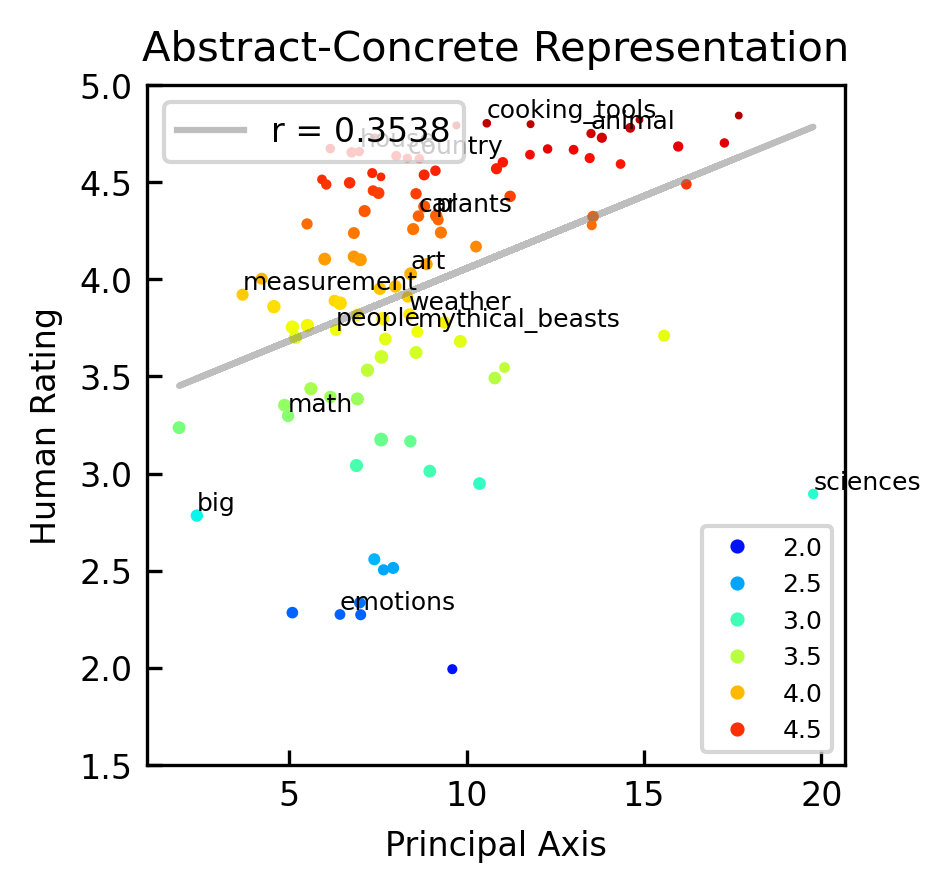

In [12]:
fig,ax,xx,yy = plot_concreteness_regression(-X_PCA_bert, C_clean, 768, concreteness_list_clean, word_select_idx, category_name)
texts = [ax.text(xx[print_idx[l]], yy[print_idx[l]], print_c[l], fontsize=6, color='black', alpha=1, ha='left', va='bottom') for l in range(len(print_c))]

0.6614666270456968
0.8749207952656691
0


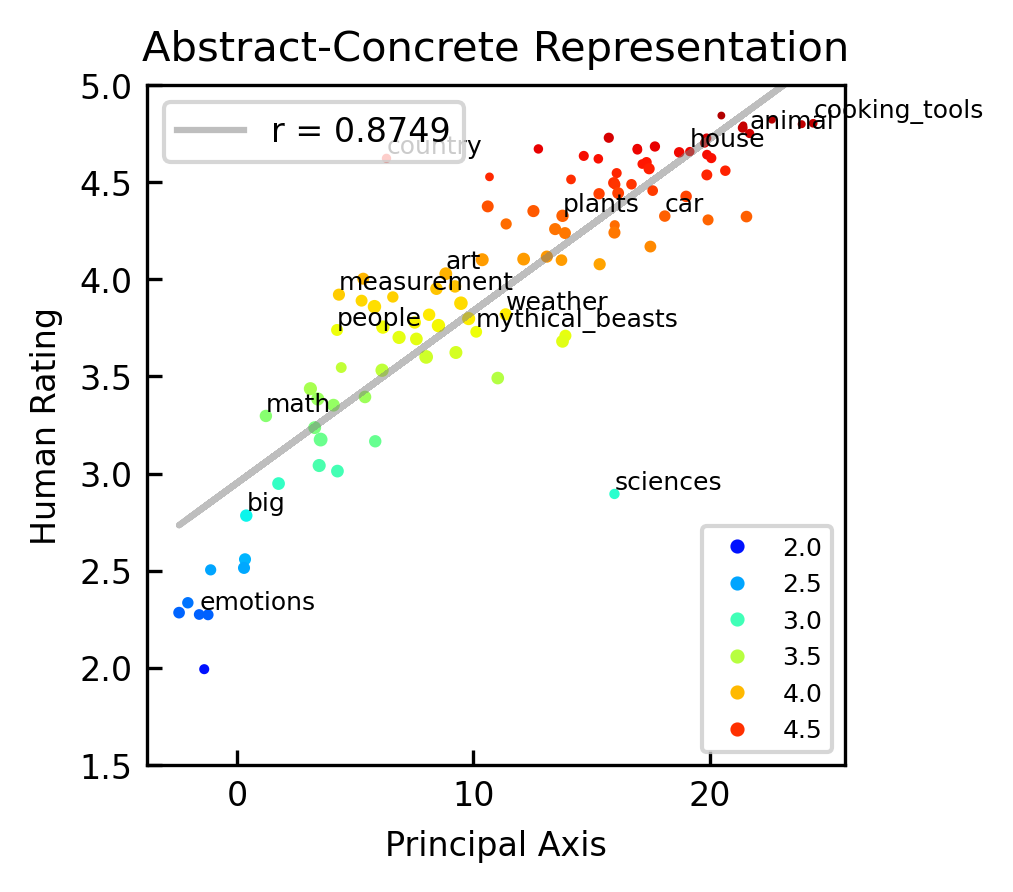

In [13]:
fig,ax,xx,yy = plot_concreteness_regression(X_PCA_grounding, C_clean, 768, concreteness_list_clean, word_select_idx, category_name)
texts = [ax.text(xx[print_idx[l]], yy[print_idx[l]], print_c[l], fontsize=6, color='black', alpha=1, ha='left', va='bottom') for l in range(len(print_c))]

0.6948358129530748
0.8001167414476772
0


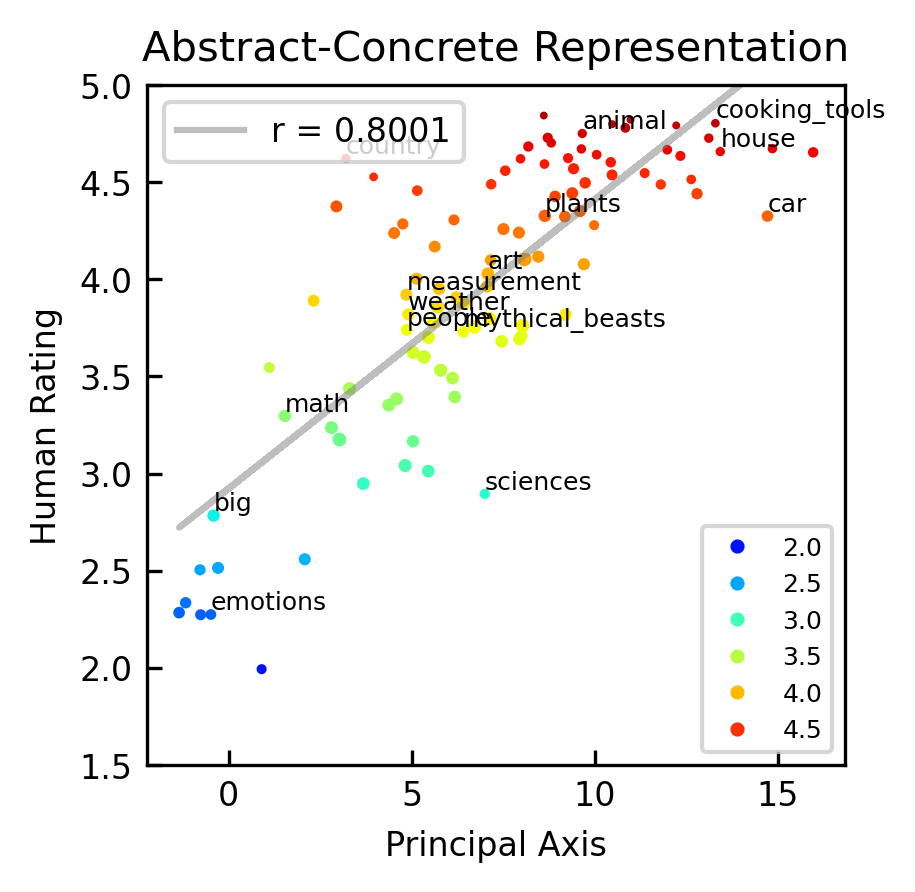

In [14]:
fig,ax,xx,yy = plot_concreteness_regression(X_PCA_relational, C_clean, 768, concreteness_list_clean, word_select_idx,category_name)
texts = [ax.text(xx[print_idx[l]], yy[print_idx[l]], print_c[l], fontsize=6, color='black', alpha=1, ha='left', va='bottom') for l in range(len(print_c))]